## Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json

names = json.loads(open("../data/names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Length of dataset: ", len(names))

Length of dataset:  32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(chtoi)
print("chtoi: ", chtoi)
print("itoch: ", itoch)
print("vocab_size: ", vocab_size)

chtoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoch:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [5]:
import random

def build_dataset(data, mode="tr", context_len=3):
  """
  Builds the dataset from the given list of words.
  
  Args:
    data (list): list of words to use
    mode (str): mode of the dataset (default: "tr" for training)
    context_len (int): length of the context window (default: 3)
  """
  
  X, y = [], []
  
  for word in data:
    context = [0] * context_len
    for ch in word + ".":
      ix = chtoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]
  
  X = torch.tensor(X)
  y = torch.tensor(y)
  
  print(f"X{mode}.shape: {X.shape}, y{mode}.shape: {y.shape}")
  return X, y


random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr = build_dataset(names[:n1])
Xval, yval = build_dataset(names[n1:n2], mode="val")
Xte, yte = build_dataset(names[n2:], mode="te")

Xtr.shape: torch.Size([182413, 3]), ytr.shape: torch.Size([182413])
Xval.shape: torch.Size([22822, 3]), yval.shape: torch.Size([22822])
Xte.shape: torch.Size([22911, 3]), yte.shape: torch.Size([22911])


In [6]:
def cmp(s, dt, t):
  """
  Utility function to compare manual and PyTorch gradients

  Args:
    s (str): name of the tensor
    dt (torch.Tensor): manual gradient
    t (torch.Tensor): PyTorch gradient
  """
  
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  max_diff = (dt - t.grad).abs().max().item()
  print(f"{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | max_diff: {max_diff:.2f}")

In [7]:
import math

n_embd = 10         # dimensionality of character embeddings vector
n_hidden = 64       # number of neurons in the hidden layer
context_len = 3     # length of the context window
gain = 5.0 / 3.0    # gain for the Kaiming initialization

"""
Parameters are initialized in non-standard ways because initializing them with
all zeroes could mask an incorrect implementation of the backpropagation.

Using b1 despite batch normalization because it's easier to compare the gradients.
"""

C =  torch.randn(vocab_size, n_embd,             requires_grad=True)
# Layer 1
W1 = torch.randn(n_embd * context_len, n_hidden, requires_grad=True) * gain / math.sqrt(n_embd * context_len)
b1 = torch.randn(n_hidden,                       requires_grad=True) * 0.1
# Layer 2
W2 = torch.randn(n_hidden, vocab_size,           requires_grad=True) * 0.1
b2 = torch.randn(vocab_size,                     requires_grad=True) * 0.1
# BatchNorm params
gamma = torch.randn(1, n_hidden,                 requires_grad=True) * 0.1 + 1.0
beta =  torch.randn(1, n_hidden,                 requires_grad=True) * 0.1

params = [C, W1, b1, W2, b2, gamma, beta]
sum(p.nelement() for p in params)

4137

In [8]:
batch_size = 32

# construct a mini-batch
ix = torch.randint(0, len(Xtr), (batch_size,))
Xb, yb = Xtr[ix], ytr[ix]     # batch X, y

In [9]:
# manual implementation of forward pass
emb = C[Xb]                                                  # embedding characters into vectors
embcat = emb.view(emb.shape[0], -1)                          # concatenate embeddings

# Linear layer 1
hprebn = embcat @ W1 + b1                                    # pre-batchnorm hidden layer

# BatchNorm layer
bnmeani = hprebn.mean(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiffsq = bndiff ** 2
bnvar = bndiffsq.sum(0, keepdim=True) / (batch_size - 1)     # Bessel's correction (N-1)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = gamma * bnraw + beta

# non-linearity
h = torch.tanh(hpreact)

# Linear layer 2 (explicit implementation of cross entropy loss)
# NOTE check source @ 21:01, 36:20
logits = h @ W2 + b2                                         # output layer
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes                          # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1                            # (1.0 / counts_sum) cannot get bit-exact backpropagation
probs = counts * counts_sum_inv
log_probs = probs.log()
loss = -log_probs[range(batch_size), yb].mean()
loss

tensor(3.5030, grad_fn=<NegBackward0>)

In [10]:
# Pytorch backward pass
training_tensors = [log_probs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logits_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiffsq, bndiff, bnmeani, hprebn, embcat, emb]

for t in training_tensors:
  t.retain_grad()

for p in params:
  p.grad = None

loss.backward()
loss

tensor(3.5030, grad_fn=<NegBackward0>)

## Atomic compute graph backpropagation

Implement backpropagation manually for the entire forward pass compute graph, using atomic operations as building blocks.

In [18]:
"""
interpretation: how loss changes with respect to each of log_probs

derivation of log_probs in relation to loss: loss = -log_probs[range(batch_size), yb].mean()
loss = - (a + b + c) / n
loss = -a/n + -b/n + -c/n
dloss_da = -1/n
dloss_db = -1/n
dloss_dc = -1/n
"""
dloss_dlogprobs = torch.zeros_like(log_probs)
dloss_dlogprobs[range(batch_size), yb] = -1.0 / batch_size
cmp("dloss_dlogprobs", dloss_dlogprobs, log_probs)

dloss_dlogprobs | exact: True  | approx: True  | max_diff: 0.00


In [19]:
"""
interpretation: how loss changes with respect to each of probs
note: intuitively, a high probability character will be simply passed through the chain rule, while a low probability will be boosted to generate a high gradient.

derivation of probs in relation to log_probs: log_probs = probs.log()
log_probs = log(a), log(b), log(c)
dlogprobs_da = 1/a
dlogprobs_db = 1/b
dlogprobs_dc = 1/c

derivation of probs in relation to loss: dlogprobs_dn * chain_rule
"""
dloss_dprobs = 1.0 / probs * dloss_dlogprobs
cmp("dloss_dprobs", dloss_dprobs, probs)

dloss_dprobs    | exact: True  | approx: True  | max_diff: 0.00


In [46]:
"""
interpretation: how loss changes with respect to each of counts_sum_inv

counts.shape: (batch_size, vocab_size)
counts_sum_inv.shape: (batch_size, 1)

matrix broadcasting with tensors:
a[3,2] * b[3,1] ---> c[3,2]
a11 * b1, a12 * b1
a21 * b2, a22 * b2
a31 * b3, a32 * b3

derivation of counts_sum_inv in relation to probs: probs = counts * counts_sum_inv
probs = a * b
dprobs_da = b
dprobs_db = a

derivation of counts_sum_inv in relation to loss: SUM of dprobs_dn * chain_rule backpropagating through matrix broadcasting
"""
dloss_dcountssuminv = (counts * dloss_dprobs).sum(1, keepdim=True)
cmp("dloss_dcountssuminv", dloss_dcountssuminv, counts_sum_inv)

dloss_dcountssuminv | exact: True  | approx: True  | max_diff: 0.00


In [51]:
"""
interpretation: how loss changes with respect to each of counts_sum

derivation of counts_sum in relation to counts_sum_inv: counts_sum_inv = counts_sum ** -1
counts_sum_inv = a ** -1
dcountssum_da = - a ** -2

derivation of counts_sum in relation to loss: dcountssum_dn * chain_rule
"""
dloss_dcountssum = -counts_sum ** -2 * dloss_dcountssuminv
cmp("dloss_dcountssum", dloss_dcountssum, counts_sum)

dloss_dcountssum | exact: True  | approx: True  | max_diff: 0.00


In [61]:
"""
interpretation: how loss changes with respect to each of counts
note: both probs and counts_sum depend on counts, so we need to backpropagate through both branches

(1st branch) derivation of counts in relation to probs: probs = counts * counts_sum_inv
probs = a * b
dprobs_da = b
dprobs_db = a

(2nd branch) derivation of counts in relation to counts_sum: counts_sum = counts.sum(1, keepdim=True)
counts.shape: (batch_size, vocab_size)
counts_sum.shape: (batch_size, 1)

matrix broadcasting with tensors:
sum(a[3,2]) ---> b[3,1]
a11 + a12 ---> b1
a21 + a22 ---> b2
a31 + a32 ---> b3

counts_sum = a + b + c
dcountssum_da = 1
dcountssum_db = 1
dcountssum_dc = 1

derivation of counts in relation to loss: dprobs_dn * chain_rule + dcountssum_dn * chain_rule
"""
dloss_dcounts = counts_sum_inv * dloss_dprobs + torch.ones_like(counts) * dloss_dcountssum
cmp("dloss_dcounts", dloss_dcounts, counts)

dloss_dcounts   | exact: True  | approx: True  | max_diff: 0.00


In [63]:
"""
interpretation: how loss changes with respect to each of norm_logits

derivation of norm_logits in relation to counts: counts = norm_logits.exp()
counts = e ** a
dcounts_da = e ** a

derivation of norm_logits in relation to loss: dcounts_dn * chain_rule
"""
dloss_dnormlogits = counts * dloss_dcounts
cmp("dloss_dnormlogits", dloss_dnormlogits, norm_logits)

dloss_dnormlogits | exact: True  | approx: True  | max_diff: 0.00


In [68]:
"""
interpretation: how loss changes with respect to each of logits_maxes
note: logits_maxes are calculated only for numerical stability of softmax function and do not affect the loss. Therefore, the gradient is zero (or close to it, due to floating point precision).

counts.shape: (batch_size, vocab_size)
counts_sum_inv.shape: (batch_size, 1)

matrix broadcasting with tensors:
a[3,2] - b[3,1] ---> c[3,2]
a11 - b1, a12 - b1
a21 - b2, a22 - b2
a31 - b3, a32 - b3

derivation of logits_maxes in relation to norm_logits: norm_logits = logits - logits_maxes
norm_logits = a + -b
dnormlogits_da = 1
dnormlogits_db = -1

derivation of logits_maxes in relation to loss: SUM of dnormlogits_dn * chain_rule backpropagating through matrix broadcasting
"""
dloss_dlogitsmaxes = -dloss_dnormlogits.sum(1, keepdim=True)
cmp("dloss_dlogitsmaxes", dloss_dlogitsmaxes, logits_maxes)

dloss_dlogitsmaxes | exact: True  | approx: True  | max_diff: 0.00


In [75]:
"""
interpretation: how loss changes with respect to each of logits
note: both norm_logits and logits_maxes depend on logits, so we need to backpropagate through both branches

(1st branch) derivation of logits in relation to norm_logits: check dloss_dlogitsmaxes

(2nd branch) derivation of logits in relation to logits_maxes: logits_maxes = logits.max(1, keepdim=True).values
logits_maxes = a
dlogitsmaxes_da = 1

derivation of logits in relation to loss: dnormlogits_dn * chain_rule + dlogitsmaxes_dn * chain_rule
"""
dloss_dlogits = dloss_dnormlogits.clone() + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dloss_dlogitsmaxes
cmp("dloss_dlogits", dloss_dlogits, logits)

dloss_dlogits   | exact: True  | approx: True  | max_diff: 0.00


Text(0.5, 1.0, 'One-hot encoding of the maximum logits')

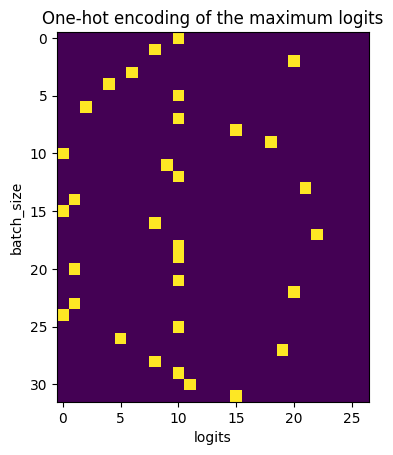

In [78]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
plt.xlabel("logits")
plt.ylabel("batch_size")
plt.title("One-hot encoding of the maximum logits")

# Sources

1. [Ground truth - Building makemore Part 4: Becoming a Backprop Ninja, By Andrej Karpathy](https://www.youtube.com/watch?v=q8SA3rM6ckI&t=6s)
2. [Yes, you should understand backprop, By Andrej Karpathy](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)
3. [Bessel's Correction](https://math.oxford.emory.edu/site/math117/besselCorrection/)
4. [Reducing the Dimensionality of Data with Neural Networks, By G. Hinton](https://www.cs.toronto.edu/~hinton/absps/science.pdf)
5. Karpathy, Andrej; Li, Fei-Fei. Deep Fragment Embeddings for Bidirectional Image Sentence Mapping, 2014. URL: https://arxiv.org/pdf/1406.5679.pdf